<div align = 'center'>
    <img src="../images/ga_logo_large.png">
</div>

---
## **Project 3: Web APIs and NLP**

----
### **Pre Processing and Model Training**

In [2]:
# import libraries needed for this notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn modules
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# metrics
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             RocCurveDisplay)

In [3]:
# read in clean file
file_path = '../data/clean_data/reddit.csv'

reddit = pd.read_csv(file_path)

# check dimensions and a couple rows
print(reddit.shape)
reddit.tail(2)

(2226, 7)


,post_title,post_text,post_title_length,post_title_wc,post_text_length,post_text_wc,topic
2224,Argentina: Buenos Aires or Salta for 3-4 extra...,Hello...I am taking a group tour in Argentina ...,51,9,1568,304,1
2225,First time investing in Duplex,"Hey guys, really need some advice as it is my ...",30,5,533,98,0


This dataset is already clean, there are no missing values or duplicates.  Let's proceed to pre-processing.

---
**Pre-Processing Stage**<br>
Set up _**X**_ matrix and **y** target vector

From the EDA stage, it was determined that the classifier we're about to build will rely on data from the `post_title` column.  The target will be the `topic` column, where a value of `0` means the row contains a real estate post, and a value of `1` means the row contains a travel post.  The aim of the classifier is to predict whether any given post is a travel post or not.

In [6]:
# set up matrix and target
X = reddit['post_title']
y = reddit['topic']

# confirm shapes
X.shape, y.shape

((2226,), (2226,))

**Calculate Baseline Accuracy**

In [8]:
y.value_counts(normalize = True)

topic
1    0.515274
0    0.484726
Name: proportion, dtype: float64

In [10]:
base_acc = y.value_counts(normalize = True)[1]

In [12]:
print(f"The classes are very well balanced in this dataset. Travel posts account for {round(base_acc, 3)*100}% of the data.\n"
"The various models that will be attempted need to beat this level of accuracy.")

The classes are very well balanced in this dataset. Travel posts account for 51.5% of the data.
The various models that will be attempted need to beat this level of accuracy.


**Training and Testing Set Splits**

In [14]:
# use 70/30 split
# although classes are almost evenly balanced, I will still stratify the data to keep the same ratio
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.7,
                                                    stratify = y,
                                                    random_state = 1976)

In [16]:
# confirm stratification
print(y_train.value_counts(normalize = True))
print('*'*35)
print(y_test.value_counts(normalize = True))

topic
1    0.515404
0    0.484596
Name: proportion, dtype: float64
***********************************
topic
1    0.51497
0    0.48503
Name: proportion, dtype: float64


Both the training set and the testing set are set up and balanced correctly to mimic the original data.

---
**Model Buildup, Training and Evaluation Stage**

Use function below to quickly evaluate models.

In [243]:
def evaluate_model(model,
                   X_train = X_train,
                   X_test = X_test,
                   y_train = y_train,
                   y_test = y_test):

    # calculate metrics for current model design/iteration------------------------
    preds = model.predict(X_test)
    
    acc = round(model.score(X_train, y_train), 3)     # training score
    acc1 = round(model.best_score_, 3)                # best accuracy score
    acc2 = round(model.score(X_test, y_test), 3)      # actual accuracy score on test set
    mis = round(1 - acc2, 3)                          # misclassification rate on test set
    prec = round(precision_score(y_test, preds), 3)   # precision score
    f1 = round(f1_score(y_test, preds), 3)            # f1 score
    # ----------------------------------------------------------------------------
    
    # plot confusion matrix and ROC curve-----------------------------------------
    
    # container
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))

    # source to tweak with the confusion matrix parameters: 
    # https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                          display_labels = ['Real Estate', 'Travel'],
                                          ax = axes[0], colorbar = False,
                                          cmap = 'Blues')


    RocCurveDisplay.from_estimator(model, X_test, y_test,
                                   ax=axes[1],
                                   color = '#00bcd4');

    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)


    plt.legend(frameon = False, loc = 'lower right')

    # source for this line: 
    # https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots
    plt.subplots_adjust(wspace=0.4)
    #---------------------------------------------------------------------------------
    
    
    # print statements----------------------------------------------------------------
    print(f'Training Score: {acc}')
    print(f'Best Accuracy Score: {acc1}')
    print(f'Actual Accuracy Score: {acc2}')
    print(f'Misclassification Rate: {mis}')
    print(f'Precision Score: {prec}')
    print(f'F1 Score: {f1}')
    #---------------------------------------------------------------------------------
    
    
    return {'train_accuracy': acc,
            'best_accuracy': acc1, 
            'test_accuracy': acc2,
            'misclassification': mis,
            'precision': prec,
            'f1_score': f1
           }    

The list below (`metrics`) will store the metrics returned from the `evaluate_model()` function.<br>
The second list at the bottom (`models`), will store the name of the models to append to dataframe at the end.

In [245]:
metrics = []
models = []

---
**Model 1**

In [22]:
# use Logistic Regression with Count Vectorizer
# build pipeline
pipe1 = Pipeline([
    ('cvec1', CountVectorizer()),
    ('model1', LogisticRegression())
])

In [24]:
# grid search parameters
params1 = {'cvec1__stop_words': [None, 'english'],
           'cvec1__max_features': [None, 1000, 5000, 10000],
           'model1__penalty': [None, 'l2']}

In [26]:
# grid search setup
gs1 = GridSearchCV(
    pipe1,
    param_grid = params1,
    n_jobs = -1,
    verbose = 1
)

In [28]:
# fit model
gs1.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=Pipeline(steps=[('cvec1', CountVectorizer()),
                                       ('model1', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec1__max_features': [None, 1000, 5000, 10000],
                         'cvec1__stop_words': [None, 'english'],
                         'model1__penalty': [None, 'l2']},
             verbose=1)

**Model 1 Evaluation**

In [107]:
# best params
gs1.best_params_

{'cvec1__max_features': None,
 'cvec1__stop_words': 'english',
 'model1__penalty': 'l2'}

In [247]:
# append model details
models.append(['gs1','LogReg and CountVectorizer'])

Training Score: 0.997
Best Accuracy Score: 0.919
Actual Accuracy Score: 0.916
Misclassification Rate: 0.084
Precision Score: 0.9
F1 Score: 0.92


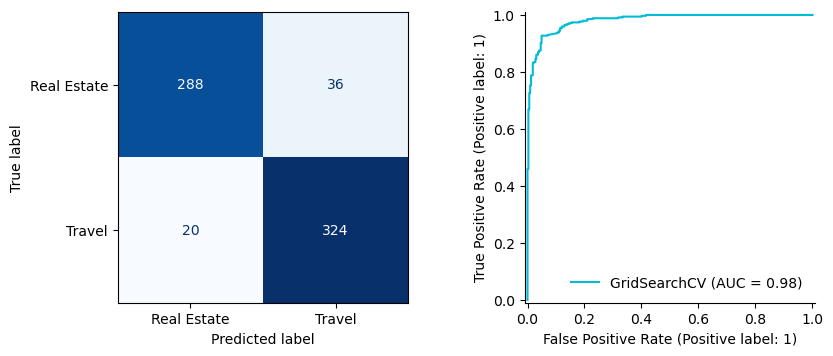

In [249]:
metrics.append(evaluate_model(gs1))
plt.savefig('../images/01_model_gs1.png')

---
**Model 2**

In [96]:
# use Logistic Regression again, this time with TfidfVectorizer
# pipeline
pipe2 = Pipeline([
    ('tvec1', TfidfVectorizer()),
    ('model2', LogisticRegression())
])

In [98]:
# grid search parameters
params2 = {
    'tvec1__stop_words': [None, 'english'],
    'tvec1__ngram_range':[(1, 1), (1, 2)],
    'tvec1__max_features': [None, 1000, 5000, 10000],
    'model2__penalty': [None, 'l2']
}

In [100]:
# grid search setup
gs2 = GridSearchCV(
    pipe2,
    param_grid = params2,
    n_jobs = -1,
    verbose = 1
)

In [102]:
# fit model
gs2.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(estimator=Pipeline(steps=[('tvec1', TfidfVectorizer()),
                                       ('model2', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model2__penalty': [None, 'l2'],
                         'tvec1__max_features': [None, 1000, 5000, 10000],
                         'tvec1__ngram_range': [(1, 1), (1, 2)],
                         'tvec1__stop_words': [None, 'english']},
             verbose=1)

**Model 2 Evaluation**

In [105]:
# best parameters
gs2.best_params_

{'model2__penalty': None,
 'tvec1__max_features': None,
 'tvec1__ngram_range': (1, 2),
 'tvec1__stop_words': 'english'}

In [251]:
# append model details
models.append(['gs2','LogReg and TfidfVectorizer'])

Training Score: 1.0
Best Accuracy Score: 0.926
Actual Accuracy Score: 0.943
Misclassification Rate: 0.057
Precision Score: 0.953
F1 Score: 0.944


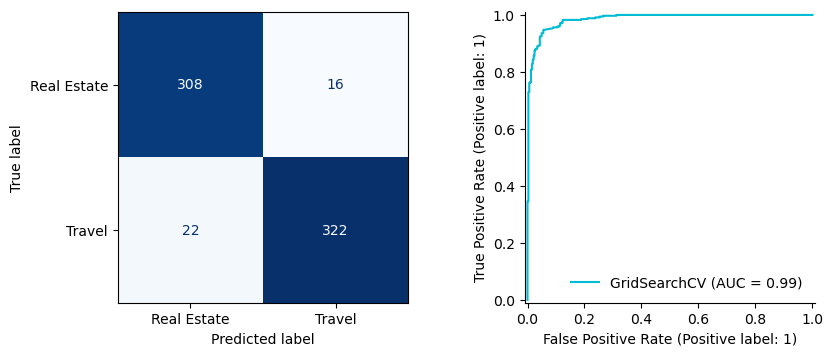

In [253]:
metrics.append(evaluate_model(gs2))
plt.savefig('../images/02_model_gs2.png')

---
**Model 3**

In [197]:
# use KNeighborsClassifier with CountVectorizer
# pipeline
pipe3 = Pipeline([
    ('cvec2', CountVectorizer()),
    ('model3', KNeighborsClassifier())
])

In [199]:
# grid search params
params3 = {
    'cvec2__stop_words': [None, 'english'],
    'cvec2__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'cvec2__max_features': [None, 1000, 5000, 10000],
    'model3__n_neighbors': [3, 5, 7, 9, 11],
    'model3__weights': ['uniform', 'distance']
}

In [201]:
# grid search setup
gs3 = GridSearchCV(
    pipe3,
    param_grid = params3,
    n_jobs = -1,
    verbose = 1
)

In [203]:
# fit model
gs3.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(estimator=Pipeline(steps=[('cvec2', CountVectorizer()),
                                       ('model3', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'cvec2__max_features': [None, 1000, 5000, 10000],
                         'cvec2__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec2__stop_words': [None, 'english'],
                         'model3__n_neighbors': [3, 5, 7, 9, 11],
                         'model3__weights': ['uniform', 'distance']},
             verbose=1)

**Model 3 Evaluaton**

In [206]:
# best params
gs3.best_params_

{'cvec2__max_features': 1000,
 'cvec2__ngram_range': (1, 2),
 'cvec2__stop_words': 'english',
 'model3__n_neighbors': 3,
 'model3__weights': 'distance'}

In [255]:
# append model details
models.append(['gs3', 'KNClass and CountVectorizer'])

Training Score: 0.972
Best Accuracy Score: 0.752
Actual Accuracy Score: 0.778
Misclassification Rate: 0.222
Precision Score: 0.725
F1 Score: 0.81


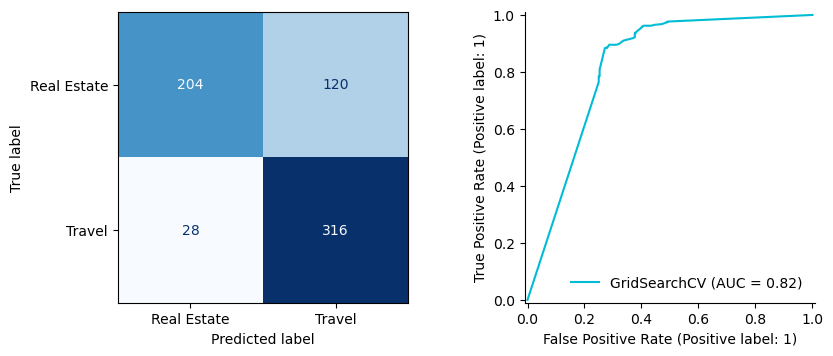

In [257]:
metrics.append(evaluate_model(gs3))
plt.savefig('../images/03_model_gs3.png')

---
**Model 4**

In [262]:
# k neighbor classifier with TfidfVectorizer
# pipeline setup
pipe4 = Pipeline([
    ('tvec2', TfidfVectorizer()),
    ('model4', KNeighborsClassifier())
])

In [268]:
# grid params
params4 = {
    'tvec2__stop_words': [None, 'english'],
    'tvec2__ngram_range':[(1, 1), (1, 2), (2, 2)],
    'tvec2__max_features': [None, 1000, 5000, 10000],
    'model4__n_neighbors': [*range(3, 22, 2)],
    'model4__weights': ['uniform', 'distance'],
    'model4__p': [1, 2]
}

In [284]:
# grid setup
gs4 = GridSearchCV(
    pipe4,
    param_grid = params4,
    cv = 7,
    n_jobs = -1,
    verbose = 1    
)

In [286]:
# fit model
gs4.fit(X_train, y_train)

Fitting 7 folds for each of 960 candidates, totalling 6720 fits


GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('tvec2', TfidfVectorizer()),
                                       ('model4', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'model4__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19,
                                                 21],
                         'model4__p': [1, 2],
                         'model4__weights': ['uniform', 'distance'],
                         'tvec2__max_features': [None, 1000, 5000, 10000],
                         'tvec2__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec2__stop_words': [None, 'english']},
             verbose=1)

**Model 4 Evaluation**

In [288]:
# best params
gs4.best_params_

{'model4__n_neighbors': 17,
 'model4__p': 2,
 'model4__weights': 'distance',
 'tvec2__max_features': None,
 'tvec2__ngram_range': (1, 1),
 'tvec2__stop_words': 'english'}

In [292]:
# append model details
models.append(['gs4', 'KNClass and TfidfVectorizer'])

Training Score: 1.0
Best Accuracy Score: 0.895
Actual Accuracy Score: 0.9
Misclassification Rate: 0.1
Precision Score: 0.96
F1 Score: 0.896


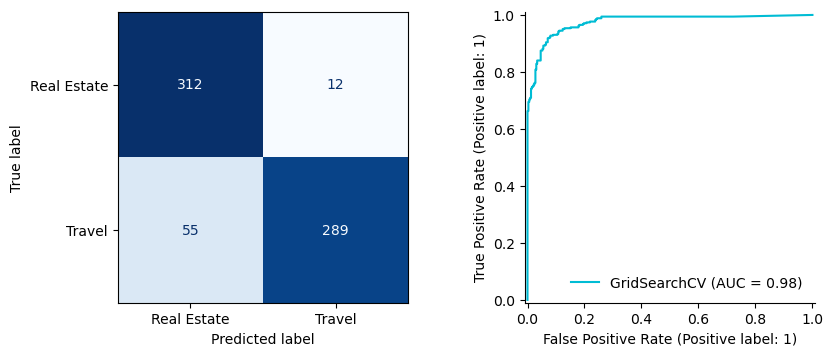

In [296]:
# metrics summary
metrics.append(evaluate_model(gs4))
plt.savefig('../images/04_model_gs4.png')

----
**Model 5**

In [353]:
# random forest class with tfidfvectorizer
# pipeline setup
pipe5 = Pipeline([
    ('tvec3', TfidfVectorizer()),
    ('model5', RandomForestClassifier())
])

In [401]:
# grid params
params5 = {
    'tvec3__stop_words': [None, 'english'],
    'model5__n_estimators': [*range(100, 500, 100)],
    'model5__max_depth': [*range(1, 50, 2)],
    'model5__random_state': [29]
}

In [403]:
# grid setup
gs5 = GridSearchCV(
    pipe5,
    param_grid = params5,
    n_jobs = -1,
    verbose = 1
)

In [405]:
# fit model
gs5.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


GridSearchCV(estimator=Pipeline(steps=[('tvec3', TfidfVectorizer()),
                                       ('model5', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'model5__max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17,
                                               19, 21, 23, 25, 27, 29, 31, 33,
                                               35, 37, 39, 41, 43, 45, 47, 49],
                         'model5__n_estimators': [100, 200, 300, 400],
                         'model5__random_state': [29],
                         'tvec3__stop_words': [None, 'english']},
             verbose=1)

**Model 5 Evaluation**

In [410]:
# best parameters
gs5.best_params_

{'model5__max_depth': 47,
 'model5__n_estimators': 100,
 'model5__random_state': 29,
 'tvec3__stop_words': 'english'}

In [429]:
# append model details
models.append(['gs5', 'RndmForest and TfidfVectorizer'])

Training Score: 0.895
Best Accuracy Score: 0.852
Actual Accuracy Score: 0.861
Misclassification Rate: 0.139
Precision Score: 0.8
F1 Score: 0.878


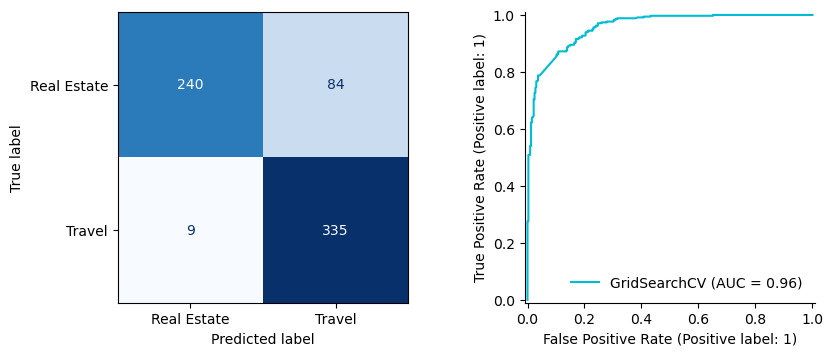

In [418]:
# metrics summary
metrics.append(evaluate_model(gs5))
plt.savefig('../images/05_model_gs5.png')

---
**Model 6**

In [434]:
# random forest class with tfidfvectorizer, part 2
# pipeline setup
pipe6 = Pipeline([
    ('tvec4', TfidfVectorizer()),
    ('model6', RandomForestClassifier())
])

In [436]:
# grid params
params6 = {
    'tvec4__stop_words': [None, 'english'],
    'tvec4__ngram_range':[(1, 1), (1, 2), (2, 2)],
    'tvec4__max_features': [None, 10000],
    'model6__n_estimators': [*range(100, 200, 20)],
    'model6__max_depth': [*range(1, 100, 5)],
    'model6__random_state': [29]
}

In [438]:
# grid setup
gs6 = GridSearchCV(
    pipe6,
    param_grid = params6,
    n_jobs = -1,
    verbose = 1
)

In [440]:
# fit model, set timer, do something else...
gs6.fit(X_train, y_train)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


GridSearchCV(estimator=Pipeline(steps=[('tvec4', TfidfVectorizer()),
                                       ('model6', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'model6__max_depth': [1, 6, 11, 16, 21, 26, 31, 36, 41,
                                               46, 51, 56, 61, 66, 71, 76, 81,
                                               86, 91, 96],
                         'model6__n_estimators': [100, 120, 140, 160, 180],
                         'model6__random_state': [29],
                         'tvec4__max_features': [None, 10000],
                         'tvec4__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec4__stop_words': [None, 'english']},
             verbose=1)

**Model 6 Evaluation**

In [447]:
# best params
gs6.best_params_

{'model6__max_depth': 96,
 'model6__n_estimators': 160,
 'model6__random_state': 29,
 'tvec4__max_features': None,
 'tvec4__ngram_range': (1, 1),
 'tvec4__stop_words': 'english'}

In [449]:
# append model details
models.append(['gs6', 'RndmForest and TfidfVectorizer'])

Training Score: 0.938
Best Accuracy Score: 0.858
Actual Accuracy Score: 0.868
Misclassification Rate: 0.132
Precision Score: 0.815
F1 Score: 0.883


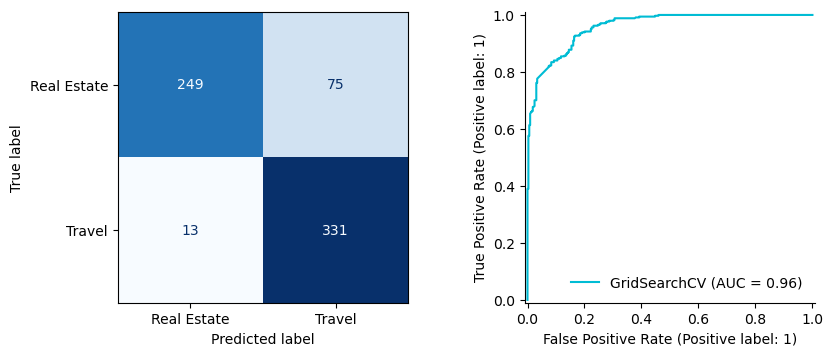

In [451]:
# metrics summary
metrics.append(evaluate_model(gs6))
plt.savefig('../images/06_model_gs6.png')

In [457]:
# build DF to serve as metrics summary table
summary = pd.DataFrame(models, columns = ['id', 'model_details'])
summary = pd.concat([summary, pd.DataFrame(metrics)], axis = 1)
summary

,id,model_details,train_accuracy,best_accuracy,test_accuracy,misclassification,precision,f1_score
0,gs1,LogReg and CountVectorizer,0.997,0.919,0.916,0.084,0.900,0.920
1,gs2,LogReg and TfidfVectorizer,1.000,0.926,0.943,0.057,0.953,0.944
2,gs3,KNClass and CountVectorizer,0.972,0.752,0.778,0.222,0.725,0.810
3,gs4,KNClass and TfidfVectorizer,1.000,0.895,0.900,0.100,0.960,0.896
4,gs5,RndmForest and TfidfVectorizer,0.895,0.852,0.861,0.139,0.800,0.878
5,gs6,RndmForest and TfidfVectorizer,0.938,0.858,0.868,0.132,0.815,0.883
